# Lets-Plot

## Initialization

### Imports

In [1]:
import os

import pandas as pd

from lets_plot import *
from lets_plot.mapping import as_discrete

In [2]:
LetsPlot.setup_html()

### Functions

In [3]:
def get_dataframes(path_list: list[str], name_list: list[str]) -> list[tuple[str, pd.DataFrame]]:
    df_items = []
    for path, name in zip(path_list, name_list):
        df = pd.read_csv(path)
        df_items.append((name, df))
    return df_items

In [4]:
def combine_dataframes(df_item_list: list[tuple[str, pd.DataFrame]], new_column: str) -> pd.DataFrame:
    df_list = []
    for name, df in df_item_list:
        new_df = df.copy()
        new_df[new_column] = name
        df_list.append(new_df)
    return pd.concat(df_list)

In [5]:
def combine_columns(df: pd.DataFrame, column_list: list[str], new_column: str) -> pd.DataFrame:
    df_list = []
    for col in column_list:
        new_df = df.copy()
        new_df.drop(columns = filter(lambda x: x != col, column_list), inplace = True)
        new_df.rename(columns = {col: new_column + '_value'}, inplace = True)
        new_df[new_column] = col
        df_list.append(new_df)
    return pd.concat(df_list)

## Meta

### Dataframes

In [6]:
exp_names = list(filter(lambda x: x.startswith('v3 RO-DR L'), os.listdir('outputs')))
exp_names = list(filter(lambda x: x.split(' ')[3] == 'WS', exp_names)) + list(filter(lambda x: x.split(' ')[3] == 'PS', exp_names))
paths = [os.path.join('outputs', exp_name, 'train_loss.csv') for exp_name in exp_names]
names = [exp_name.replace('v3 RO-DR L ', '').replace('WS ', 'weasel ').replace('PS ', 'protoseg ') 
         for exp_name in exp_names]

dataframes = get_dataframes(paths, names)
combined_df = combine_dataframes(dataframes, 'method')
combined_df['duration'] = combined_df['duration'] / 1000
combined_df[['method', 'scenario']] = combined_df['method'].str.split(' ', expand = True)

combined_df

,epoch,duration,post_gpu_percent,loss,method,scenario
0,1,45.684834,47.717625,15.677386,weasel,all
1,2,47.172336,47.717625,11.462608,weasel,all
2,3,48.211013,47.717625,10.499323,weasel,all
3,4,47.432793,47.717625,9.782793,weasel,all
4,5,46.651022,47.717625,9.134654,weasel,all
...,...,...,...,...,...,...
195,196,48.687301,44.675484,0.316745,protoseg,skeleton
196,197,49.323421,44.675484,0.315297,protoseg,skeleton
197,198,48.106937,44.675484,0.324295,protoseg,skeleton
198,199,48.720882,44.675484,0.316981,protoseg,skeleton


### Loss

In [7]:
ggplot(combined_df) \
+ geom_line(aes(x = 'epoch', y = 'loss', color = 'scenario')) \
+ facet_grid(y = 'method', scales = 'free_y', y_order=0) \
+ ggsize(1200, 800) \
+ flavor_darcula()

- "weasel" method is less stable than "protoseg" method, but better at optimizing "all" scenarios and others.
- "protoseg" method has trouble optimizing "all" scenarios and "contour" scenario.
- "all" scenarios is less stable than "separated" scenarios, especially for "protoseg" method.
- "all-more-embeds" scenario for "protoseg" method is not significantly different than "all" scenario.

### Duration and GPU

In [8]:
combined_df_flat = combine_columns(combined_df, ['duration', 'post_gpu_percent'], 'metric')

ggplot(combined_df_flat) \
+ geom_line(aes(x = 'epoch', y = 'metric_value', color = 'scenario')) \
+ facet_grid(x = 'method', y = 'metric', scales = 'free_y', x_order=0, y_order=0) \
+ ggsize(1200, 800) \
+ flavor_darcula() \
+ theme(panel_border=element_rect(size=1), legend_position = 'bottom')

- "weasel" method is slower than "protoseg" method, but the GPU usage is little bit lower, note that "protoseg" method has a much higher batch size.
- Order of scenarios from slowest to fastest: "region" > "all" = "skeleton" > "contour" > "point" > "grid".
- Note that "all" scenarios include "point_old" and "grid_old".
- "region" scenario is significantly slower than others.
- "all-more-embeds" scenario use same amount of time, but higher GPU usage than the "all" scenario. 
- "point" scenarios has significantly higher GPU usage than others.

## Tune

### Dataframes

In [9]:
exp_names = list(filter(lambda x: x.startswith('v3 RO-DR L'), os.listdir('outputs')))
exp_names = list(filter(lambda x: x.split(' ')[3] == 'WS', exp_names)) + list(filter(lambda x: x.split(' ')[3] == 'PS', exp_names))
paths = [os.path.join('outputs', exp_name, 'tuned_score.csv') for exp_name in exp_names]
names = [exp_name.replace('v3 RO-DR L ', '').replace('WS ', 'weasel ').replace('PS ', 'protoseg ')
         for exp_name in exp_names]

dataframes = get_dataframes(paths, names)
combined_df = combine_dataframes(dataframes, 'method')
combined_df['duration'] = combined_df['duration'] / 1000
combined_df[['method', 'scenario']] = combined_df['method'].str.split(' ', expand = True)
combined_df['scenario'] = combined_df['scenario'].apply(lambda x: x if 'all' in x else 'separated')

combined_df_full = combined_df.copy()
combined_df = combined_df[combined_df['n_shots'] == 10]

combined_df

,epoch,n_shots,sparsity_mode,sparsity_value,duration,post_gpu_percent,iou_oc,iou_od,method,scenario
35,40,10,point,10,66.320192,9.667795,0.797643,0.844637,weasel,all
36,40,10,grid,25,57.778975,9.667795,0.855947,0.909237,weasel,all
37,40,10,contour,1,68.922065,13.405106,0.716068,0.824490,weasel,all
38,40,10,skeleton,1,68.839285,9.667795,0.573691,0.753755,weasel,all
39,40,10,region,1,108.846673,9.667795,0.845365,0.881676,weasel,all
...,...,...,...,...,...,...,...,...,...,...
0,40,10,skeleton,1,3.199206,44.675484,0.557226,0.800123,protoseg,separated
1,80,10,skeleton,1,2.998072,44.675484,0.556633,0.800725,protoseg,separated
2,120,10,skeleton,1,3.102829,44.675484,0.609516,0.866522,protoseg,separated
3,160,10,skeleton,1,2.990655,44.675484,0.601538,0.836642,protoseg,separated


### Score

In [10]:
combined_df_flat = combine_columns(combined_df, ['iou_od', 'iou_oc'], 'iou')

ggplot(combined_df_flat[combined_df_flat['method'] == 'protoseg']) \
+ geom_line(aes(x = as_discrete('epoch'), y = 'iou_value', color = 'scenario', linetype = 'method'),
            tooltips=layer_tooltips().line('@method @scenario').line('@iou_value')) \
+ facet_grid(x = 'sparsity_mode', y = 'iou', scales = 'fixed', x_order=1, y_order=0) \
+ ggsize(1800, 800) \
+ flavor_darcula() \
+ theme(panel_border=element_rect(size=1), legend_position='top')

In [11]:
point_grid_df_flat = combined_df_flat[combined_df_flat['scenario'] == 'all']
point_grid_df_flat = point_grid_df_flat[point_grid_df_flat['sparsity_mode'].isin(['point', 'grid', 'point_old', 'grid_old'])]
point_grid_df_flat['sparsity_newness'] = point_grid_df_flat['sparsity_mode'].apply(lambda x: 'new' if 'old' not in x else 'old')
point_grid_df_flat['sparsity_mode'] = point_grid_df_flat['sparsity_mode'].apply(lambda x: x.replace('_old', ''))
point_grid_df_flat['method__sparsity_mode'] = point_grid_df_flat['method'] + ' ' + point_grid_df_flat['sparsity_mode']

ggplot(point_grid_df_flat) \
+ geom_line(aes(x = as_discrete('epoch'), y = 'iou_value', color = 'sparsity_newness')) \
+ facet_grid(x = 'method__sparsity_mode', y = 'iou', scales = 'fixed', x_order=0, y_order=0) \
+ ggsize(1200, 600) \
+ flavor_darcula() \
+ theme(panel_border=element_rect(size=1), legend_position='top')

### Duration and GPU

In [12]:
combined_df_full_flat = combine_columns(combined_df_full, ['duration', 'post_gpu_percent'], 'metric')

ggplot(combined_df_full_flat) \
+ geom_line(aes(x = as_discrete('epoch'), y = 'metric_value', color = 'scenario', linetype = 'method', size = as_discrete('n_shots', order=1)),
            tooltips=layer_tooltips().line('@method @scenario').format('@metric_value', '.2f').line('@metric_value')) \
+ facet_grid(x = 'sparsity_mode', y = 'metric', scales = 'free_y', x_order=1, y_order=0) \
+ ggsize(1800, 800) \
+ flavor_darcula() \
    + scale_size(range=[1, 2]) \
+ theme(panel_border=element_rect(size=1), legend_position='top')

## Weasel Tune

### Dataframes

In [13]:
exp_names = list(filter(lambda x: x.startswith('v3 RO-DR L WS'), os.listdir('outputs')))
paths = [os.path.join('outputs', exp_name, 'tuning_score.csv') for exp_name in exp_names]
names = [exp_name.replace('v3 RO-DR L WS ', '')
         for exp_name in exp_names]

dataframes = get_dataframes(paths, names)
combined_df = combine_dataframes(dataframes, 'scenario')
combined_df['test_duration'] = combined_df['test_duration'] / 1000
combined_df['scenario'] = combined_df['scenario'].apply(lambda x: x if 'all' in x else 'separated')
combined_df = combined_df[combined_df['n_shots'] == 10]

combined_df

,epoch,n_shots,sparsity_mode,sparsity_value,tune_epoch,test_duration,iou_oc,iou_od,scenario
175,40,10,point,10,8,1.399436,0.696245,0.830328,all
176,40,10,point,10,16,1.369836,0.778197,0.891231,all
177,40,10,point,10,24,1.373589,0.860368,0.785322,all
178,40,10,point,10,32,1.403712,0.849758,0.852342,all
179,40,10,point,10,40,1.437532,0.797643,0.844637,all
...,...,...,...,...,...,...,...,...,...
20,200,10,skeleton,1,8,1.332888,0.672186,0.820802,separated
21,200,10,skeleton,1,16,1.344625,0.567783,0.687276,separated
22,200,10,skeleton,1,24,1.366027,0.543621,0.684870,separated
23,200,10,skeleton,1,32,1.264890,0.546931,0.754949,separated


### Score

In [14]:
ggplot(combined_df) \
+ geom_line(aes(x = as_discrete('tune_epoch'), y = 'iou_od', color = 'scenario')) \
+ facet_grid(x = 'epoch', y = 'sparsity_mode', scales = 'fixed', x_order=1, y_order=1) \
+ ggsize(1800, 1600) \
+ flavor_darcula() \
+ theme(panel_border=element_rect(size=1), legend_position='top')

## Exploration

In [15]:
weasel_train_loss = pd.read_csv('outputs/v1 RO-DR L WS/train_loss.csv')
protoseg_train_loss = pd.read_csv('outputs/v1 RO-DR L PS/train_loss.csv')

train_loss = combine_dataframes([('weasel', weasel_train_loss), ('protoseg', protoseg_train_loss)], 'method')

In [16]:
ggplot(train_loss) \
+ geom_line(aes(x = 'epoch', y = 'duration', color = 'method')) \
+ facet_grid('method', scales = 'free') \
+ ggsize(800, 300) + flavor_darcula()

In [17]:
ggplot(train_loss) \
+ geom_line(aes(x = 'epoch', y = 'duration', color = 'method')) \
+ facet_grid('method', scales = 'free') \
+ ggsize(800, 300) + flavor_darcula() \
+ theme(legend_position = 'left', 
        line=element_line(size=2), 
        # rect=element_rect(size=10),
        text=element_text(size=10),
        axis_text=element_text(size=5),
        axis_title=element_text(size=20),
        axis_line_y=element_line(size=2),
        panel_border=element_rect(size=2, color="yellow"),
        plot_margin=margin(0.5, 0.5, 0.5, 0.5),
        strip_text='blank')

# Matplotlib

## Initialization

### Imports

In [18]:
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Meta

### Loss & Duration

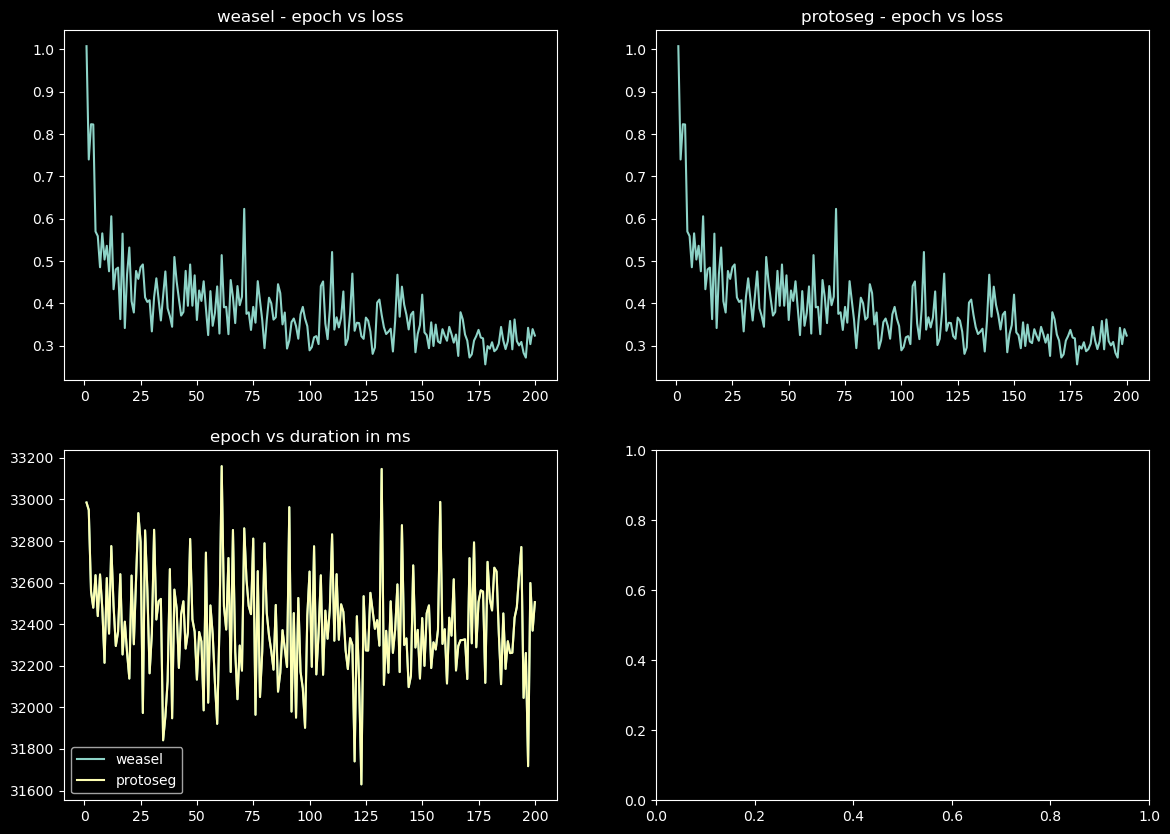

In [19]:
weasel_train_loss = pd.read_csv('outputs/v1 RO-DR L WS/train_loss.csv')
protoseg_train_loss = pd.read_csv('outputs/v1 RO-DR L WS/train_loss.csv')

_, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0][0].set_title('weasel - epoch vs loss')
axs[0][0].plot(weasel_train_loss['epoch'], weasel_train_loss['loss'])

axs[0][1].set_title('protoseg - epoch vs loss')
axs[0][1].plot(protoseg_train_loss['epoch'], protoseg_train_loss['loss'])

axs[1][0].set_title('epoch vs duration in ms')
axs[1][0].plot(weasel_train_loss['epoch'], weasel_train_loss['duration'], label = 'weasel')
axs[1][0].plot(protoseg_train_loss['epoch'], protoseg_train_loss['duration'], label = 'protoseg')
axs[1][0].legend()

## Tune

### Score

(0.0, 1.0)

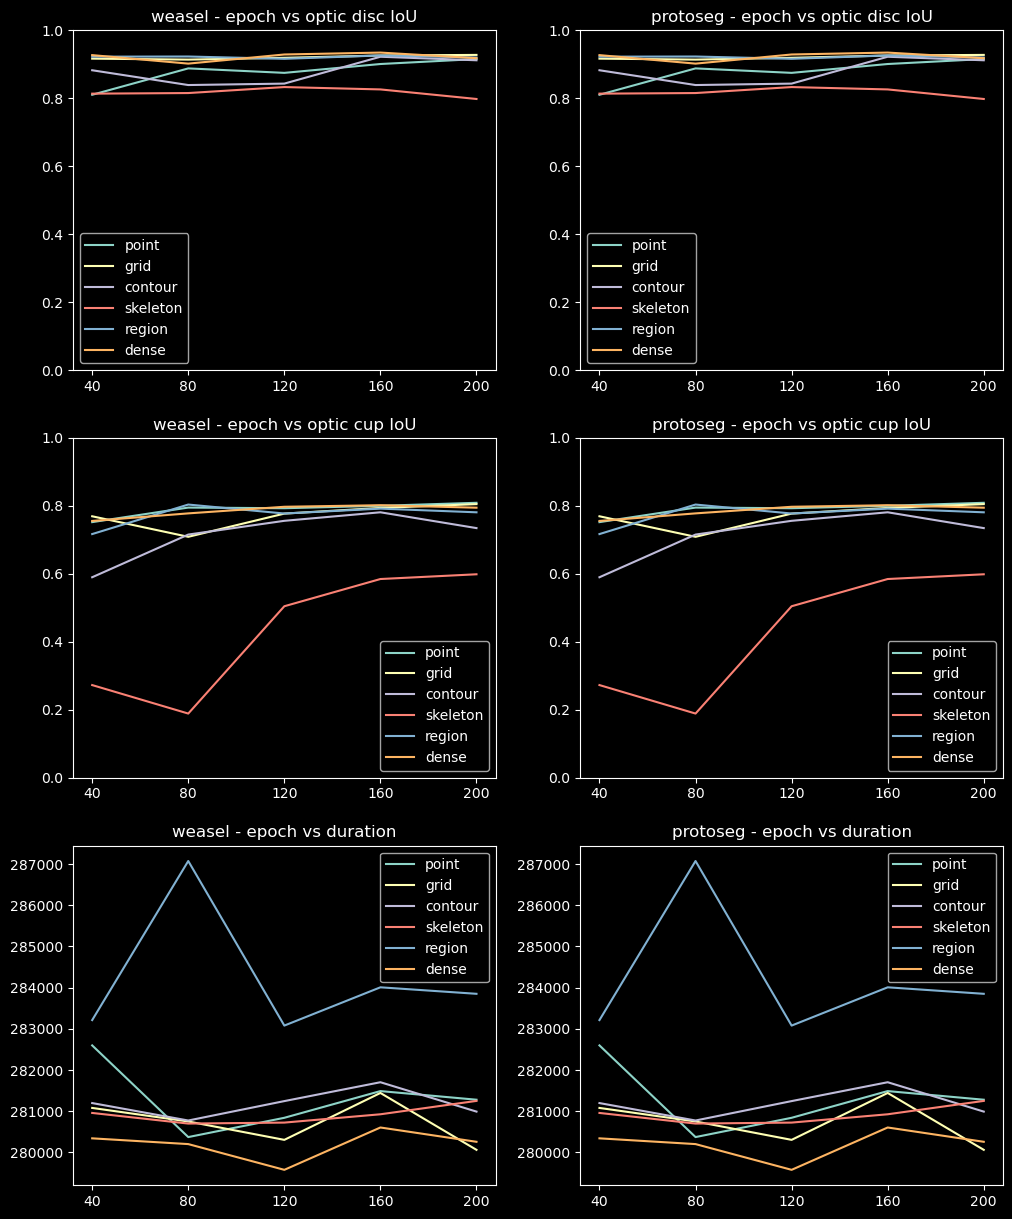

In [20]:
weasel_tuned_score = pd.read_csv('outputs/v1 RO-DR L WS/tuned_score.csv')
protoseg_tuned_score = pd.read_csv('outputs/v1 RO-DR L WS/tuned_score.csv')

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(3, 2, figsize=(12,15))

for sm in sparsity_modes:
    weasel_df = weasel_tuned_score[weasel_tuned_score['sparsity_mode'] == sm]
    weasel_epochs = [str(ep) for ep in weasel_df['epoch']]
    axs[0][0].plot(weasel_epochs, weasel_df['iou_od'], label = sm)
    axs[1][0].plot(weasel_epochs, weasel_df['iou_oc'], label = sm)
    axs[2][0].plot(weasel_epochs, weasel_df['duration'], label = sm)

    protoseg_df = protoseg_tuned_score[protoseg_tuned_score['sparsity_mode'] == sm]
    protoseg_epochs = [str(ep) for ep in protoseg_df['epoch']]
    axs[0][1].plot(protoseg_epochs, protoseg_df['iou_od'], label = sm)
    axs[1][1].plot(protoseg_epochs, protoseg_df['iou_oc'], label = sm)
    axs[2][1].plot(protoseg_epochs, protoseg_df['duration'], label = sm)

axs[0][0].set_title('weasel - epoch vs optic disc IoU')
axs[1][0].set_title('weasel - epoch vs optic cup IoU')
axs[2][0].set_title('weasel - epoch vs duration')
axs[0][0].legend()
axs[1][0].legend()
axs[2][0].legend()
axs[0][0].set_ylim([0, 1])
axs[1][0].set_ylim([0, 1])
axs[0][1].set_title('protoseg - epoch vs optic disc IoU')
axs[1][1].set_title('protoseg - epoch vs optic cup IoU')
axs[2][1].set_title('protoseg - epoch vs duration')
axs[0][1].legend()
axs[1][1].legend()
axs[2][1].legend()
axs[0][1].set_ylim([0, 1])
axs[1][1].set_ylim([0, 1])

## Weasel Tune

### Score

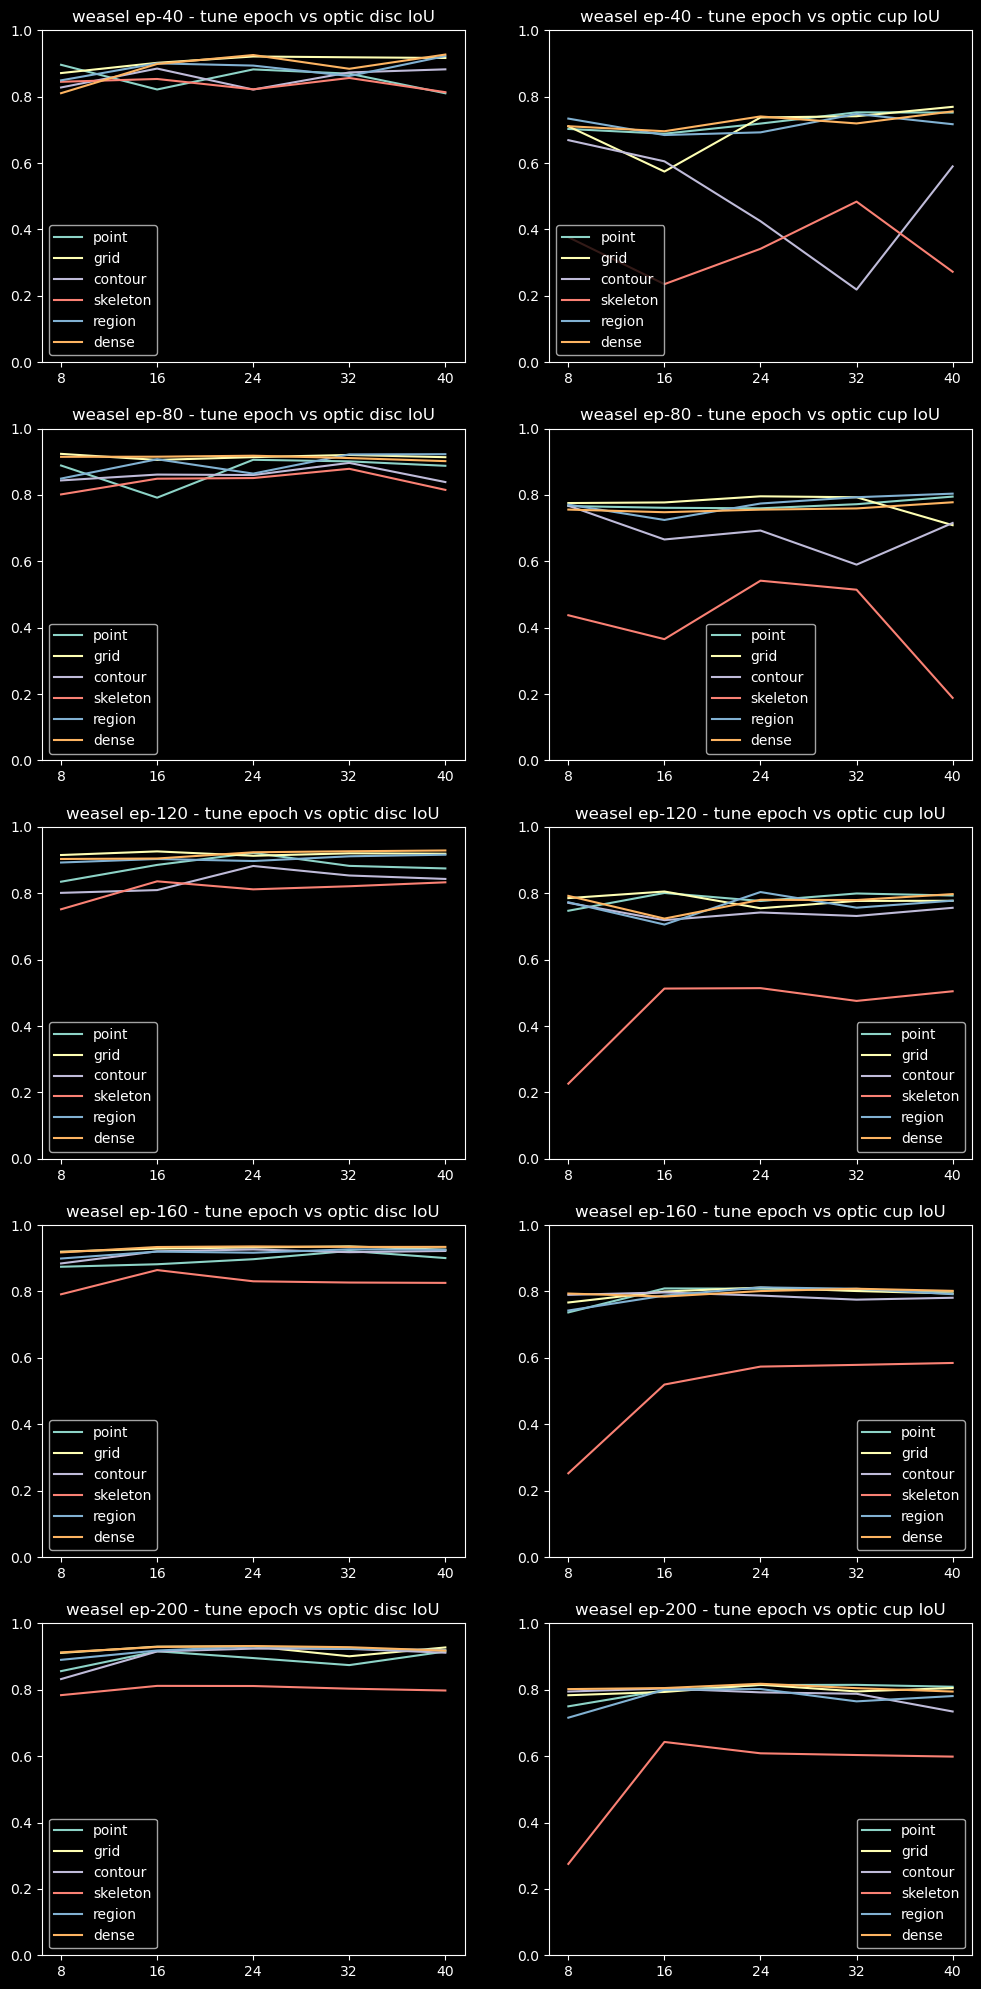

In [21]:
weasel_tuning_score = pd.read_csv('outputs/v1 RO-DR L WS/tuning_score.csv')
weasel_epochs = weasel_tuning_score['epoch'].unique()

sparsity_modes = ['point', 'grid', 'contour', 'skeleton', 'region', 'dense']

_, axs = plt.subplots(len(weasel_epochs), 2, figsize=(12,5*len(weasel_epochs)))

for i, ep in enumerate(weasel_epochs):
    for sm in sparsity_modes:
        weasel_df = weasel_tuning_score[(weasel_tuning_score['sparsity_mode'] == sm) & (weasel_tuning_score['epoch'] == ep)]
        weasel_tune_epochs = [str(tep) for tep in weasel_df['tune_epoch']]
        axs[i][0].plot(weasel_tune_epochs, weasel_df['iou_od'], label = sm)
        axs[i][1].plot(weasel_tune_epochs, weasel_df['iou_oc'], label = sm)
        # axs[i][2].plot(weasel_tune_epochs, weasel_df['test_duration'], label = sm)

    axs[i][0].set_title(f'weasel ep-{ep} - tune epoch vs optic disc IoU')
    axs[i][1].set_title(f'weasel ep-{ep} - tune epoch vs optic cup IoU')
    # axs[i][2].set_title(f'weasel ep-{ep} - tune epoch vs test duration')
    axs[i][0].legend()
    axs[i][1].legend()
    # axs[i][2].legend()
    axs[i][0].set_ylim([0, 1])
    axs[i][1].set_ylim([0, 1])

# Other